In [88]:
import numpy as np
from scipy.interpolate import interp2d, RectBivariateSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import struct
import os
from numba import jit, njit
import time


from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter

# tight_layout() only considers ticklabels, axis labels, and titles. Thus, other artists may be clipped and also may overlap.
# [left, bottom, right, top] in normalized (0, 1) figure coordinates
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 1.5,
            'figure.dpi': 300}
plt.rcParams.update(rcparams)
plt.style.use('seaborn')

<Figure size 2400x1650 with 0 Axes>

In [2]:
def read_topo(fname):
    '''Return topography binary file
    Header
    ------
        nx, ny : rightward, topward
        pad : number of padding
        
    Return
    ------
        topo : (ny, nx), fast axis is pointing right
    '''
    with open(fname, 'rb') as fout:
        nx, ny, pad = np.frombuffer(fout.read(12), dtype='int32')
        topo = np.frombuffer(fout.read((nx + 2 * pad) * (ny + 2 * pad) * 4), dtype=np.float32)
        topo = topo.reshape(nx + 2 * pad, ny + 2 * pad).T  # transpose (nx, ny) to (ny, nx)
        return topo.copy()
    
def write_topo(topo, fname, nx, ny, pad):
    with open(fname, 'w') as fout:
        header = np.array([nx, ny, pad], dtype='int32')
        header.tofile(fout)
        topo.astype(np.float32).tofile(fout)

In [12]:
def mesh_info(fmesh_name, mz, nx, ny, nvar=3):
    vp_depth = np.zeros((mz, 2), dtype=np.float32)
    vs_depth = np.zeros((mz, 2), dtype=np.float32)
    rho_depth = np.zeros((mz, 2), dtype=np.float32)
    with open(fmesh_name, 'rb') as fmesh:
        for i in range(mz):
            data = np.fromfile(fmesh, count=4 * 3 * nx * ny, dtype=np.float32).reshape(ny, nx, 3)
            vp_depth[i] = [np.max(data[:, :, 0]), np.min(data[:, :, 0])]
            vs_depth[i] = [np.max(data[:, :, 1]), np.min(data[:, :, 1])]
            rho_depth[i] = [np.max(data[:, :, 2]), np.min(data[:, :, 2])]
    return vp_depth, vs_depth, rho_depth

In [25]:
def read_mesh_slice(fmesh, orient, n, nx, ny, nz, skip=1):
    '''Read a slice of Vs from the mesh
    :fmesh:     mesh file name
    :nx,ny,nz:  shape of the mesh
    :orient:    orientation of the slice, "x" or "y"
    :n:         the location of the slice along the assigned orientation
    '''
    with open(fmesh, 'rb') as fid:
        if orient == 'x':
            res = np.zeros((nz // skip, ny // skip), dtype=np.float32)
            for i in range(0, nz, skip):
                if i % 100 < 20:
                    print(f'Processing {i} / {nz}')
                for j in range(0, ny, skip):
                    offset = 4 * (i * (ny * nx * 3) + j * (nx * 3) + n * 3 + 1)
                    fid.seek(offset, 0)
                    res[i // skip, j // skip] = struct.unpack('f', fid.read(4))[0]
        if orient == 'y':
            res = np.zeros((nz // skip, nx // skip), dtype=np.float32)
            for i in range(0, nz, skip):
                if i % 100 < 20:
                    print(f'Processing {i} / {nz}')
                for j in range(0, nx, skip):
                    offset = 4 * (i * (ny * nx * 3) + n * (nx * 3) + j * 3 + 1)
                    fid.seek(offset, 0)
                    res[i // skip, j // skip] = struct.unpack('f', fid.read(4))[0]
        if orient == 'z':
            res = np.fromfile(fid, count=ny * nx * 3,
                              offset = n * ny * nx * 4 * 3).reshape(ny, nx, 3)
            res = res[::skip, ::skip, 1]
            
    return res

In [141]:
@njit(fastmath=True, parallel=True)
def compute_gradient(topo, dh, pad=8):
    difx = np.empty(topo.shape, dtype=np.float32)
    dify = np.empty(topo.shape, dtype=np.float32)
    difx[2:-2, :] = ((topo[3:-1, :] - topo[1:-3, :]) * 2 / 3 - (topo[4::, :] - topo[0:-4, :]) / 12) / dh
    dify[:, 2:-2] = ((topo[:, 3:-1] - topo[:, 1:-3]) * 2 / 3 - (topo[:, 4::] - topo[:, 0:-4]) / 12) / dh
    difx[:2, :]  = (- 25 / 12 * topo[:2, :] + 4 *  topo[1:3, :] - 3 * topo[2:4, :] + 
                      4 / 3 * topo[3:5, :] - 1 / 4 * topo[4:6, :] )  / dh
    difx[-2:, :] = (25 / 12 * topo[-2:, :] - 4 *  topo[-3:-1, :] + 3 * topo[-4:-2, :] - 
                      4 / 3 * topo[-5:-3, :] + 1 / 4 * topo[-6:-4, :] )  / dh
    dify[:, :2]  = (- 25 / 12 * topo[:, :2] + 4 *  topo[:, 1:3] - 3 * topo[:, 2:4] + 
                      4 / 3 * topo[:, 3:5] - 1 / 4 * topo[:, 4:6] )  / dh
    dify[:, -2:] = (25 / 12 * topo[:, -2:] - 4 *  topo[:, -3:-1] + 3 * topo[:, -4:-2] - 
                      4 / 3 * topo[:, -5:-3] + 1 / 4 * topo[:, -6:-4] )  / dh
    return difx[pad : -pad, pad : -pad], dify[pad : -pad, pad : -pad]

@njit(fastmath=True, parallel=True)
def compute_norm(g, difx, dify):
    return np.sqrt((g * difx) ** 2 + (g * dify) ** 2 + 1)


In [154]:
def compute_ratio(fname_topo, fname_mesh, nx, ny, nz, dh, difx, dify):
    '''the ratio to determine dt
    Formula:
        ratio = dh_min / vp_max / norm, where norm = sqrt((gfx)**2 + (gfy) ** 2 + 1)
        dt should be smaller than ratio
    '''
    topo = read_topo(fname_topo)
    dh_z = ((topo + H) / H * dh)[pad : pad + ny, pad : pad + nx]  # possibly smaller than dh, when topo < 0
    dh_z[dh_z > dh] = dh  # Minimum grid spacing, at most regular dh
    ratio = np.zeros((nz, ), dtype=np.float32)
    normmax = np.zeros((nz, ), dtype=np.float32)
    with open(fname_mesh, 'rb') as fmesh:
        for i in range(nz):
            g = (nz - 1 - i) / (nz - 2) if i > 1 else np.float32(1.0)
            fmesh.seek(0)
            buffer = np.fromfile(fmesh, dtype=np.float32, count=3 * nx * ny, offset = 4 * 3 * nx * ny * i)
            vp = buffer[::3].reshape(ny, nx)  
            norm = compute_norm(g, difx, dify)
            normmax[i] = np.max(norm)
            rt = np.divide(dh_z, (norm * vp))
            ratio[i] = np.min(rt)
            print(f"\rLayer {i} / {nz}: Max vp = {np.max(vp)}, Min ratio = {ratio[i]}",
                  end="\r", flush=True)
            
    return ratio, normmax

In [40]:
def set_dt_vp(ratio, normmax, dh, alpha=0.6):
    suggest_dt = np.min(ratio) / alpha
    suggest_vpmax = dh / suggest_dt / alpha / np.max(normmax)
    return suggest_dt, suggest_vpmax

### Generate topography from DEM

In [16]:
nx, ny = 9504, 7020
pad = 8
dh = 20
nz = 3072
H = (nz - 2) * dh

grid = np.fromfile('surf.grid', dtype='float64').reshape(ny, nx, 3)
lon = grid[:, :, 0]
lat = grid[:, :, 1]
print(f"The boudnaries are WENS: {np.min(lon)}, {np.max(lon)}, {np.max(lat)}, {np.min(lat)}")
del grid

print(f"Left lower corner: {lon[0, 0]}, {lat[0, 0]}\n"
      f"Right lower corner: {lon[0, -1]}, {lat[0, -1]}\n"
      f"Left upper corner: {lon[-1, 0]}, {lat[-1, 0]}\n"
      f"Right upper corner: {lon[-1, -1]}, {lat[-1, -1]}")

dem_head = np.genfromtxt('dem.txt', dtype='float')
print(dem_head)

NY, NX = int(dem_head[0]), int(dem_head[1])
left, right, bot, top = dem_head[2:]

# dem[lon][lat]
dem = np.fromfile('dem.bin', dtype=np.float32).reshape(NY, NX)
vmin = np.min(dem)
vmax = np.max(dem)
dx = (right - left) / NX
dy = (top - bot) / NY

The boudnaries are WENS: -119.3309098848646, -116.77297541421393, 35.13480950243679, 33.06957796456456
Left lower corner: -119.3309098848646, 34.149236516966624
Right lower corner: -117.7401908038864, 33.06957796456456
Left upper corner: -118.3704310693418, 35.13480950243679
Right upper corner: -116.77297541421393, 34.04292416669585
[22452.         27745.          -119.33944444  -116.77055556
    33.06055556    35.13944444]


In [4]:
# extract topography, note to leave 8 surrounding layers
def obtain_topo(nx, ny, pad, f_topo='topography.bin'):
    topo = np.zeros(((nx + 2 * pad), (ny + 2 * pad)), dtype=np.float32)
    idx = np.round((lon - left) / dx)
    idy = np.round((top - lat) / dy)
    for i in range(nx):
        for j in range(ny):
            topo[i + pad, j + pad] = dem[int(idy[j, i]), int(idx[j, i])]

    f = RectBivariateSpline(pad + np.arange(nx), pad + np.arange(ny), topo[pad : nx + pad, pad : ny + pad])

    for i in range(nx + 2 * pad):
        for j in range(pad):
            topo[i, j] = f(i, j)
        for j in range(ny + pad, ny + 2 * pad):
            topo[i, j] = f(i, j)

    for i in range(pad):
        for j in range(pad, ny + pad):
            topo[i, j] = f(i, j)
    for i in range(nx + pad, nx + 2 * pad):
        for j in range(pad, ny + pad):
            topo[i, j] = f(i, j)

    write_topo(topo, f_topo, nx, ny, pad)
    return topo
        
f_topo = 'topography.bin'
if not os.path.isfile(f_topo):
    topo = obtain_topo(nx, ny, pad, f_topo=f_topo)
else:
    topo = read_topo(f_topo)

Topography shape: (7036, 9520)
Max topo = 3311.554443359375, Min topo = -5.650579452514648


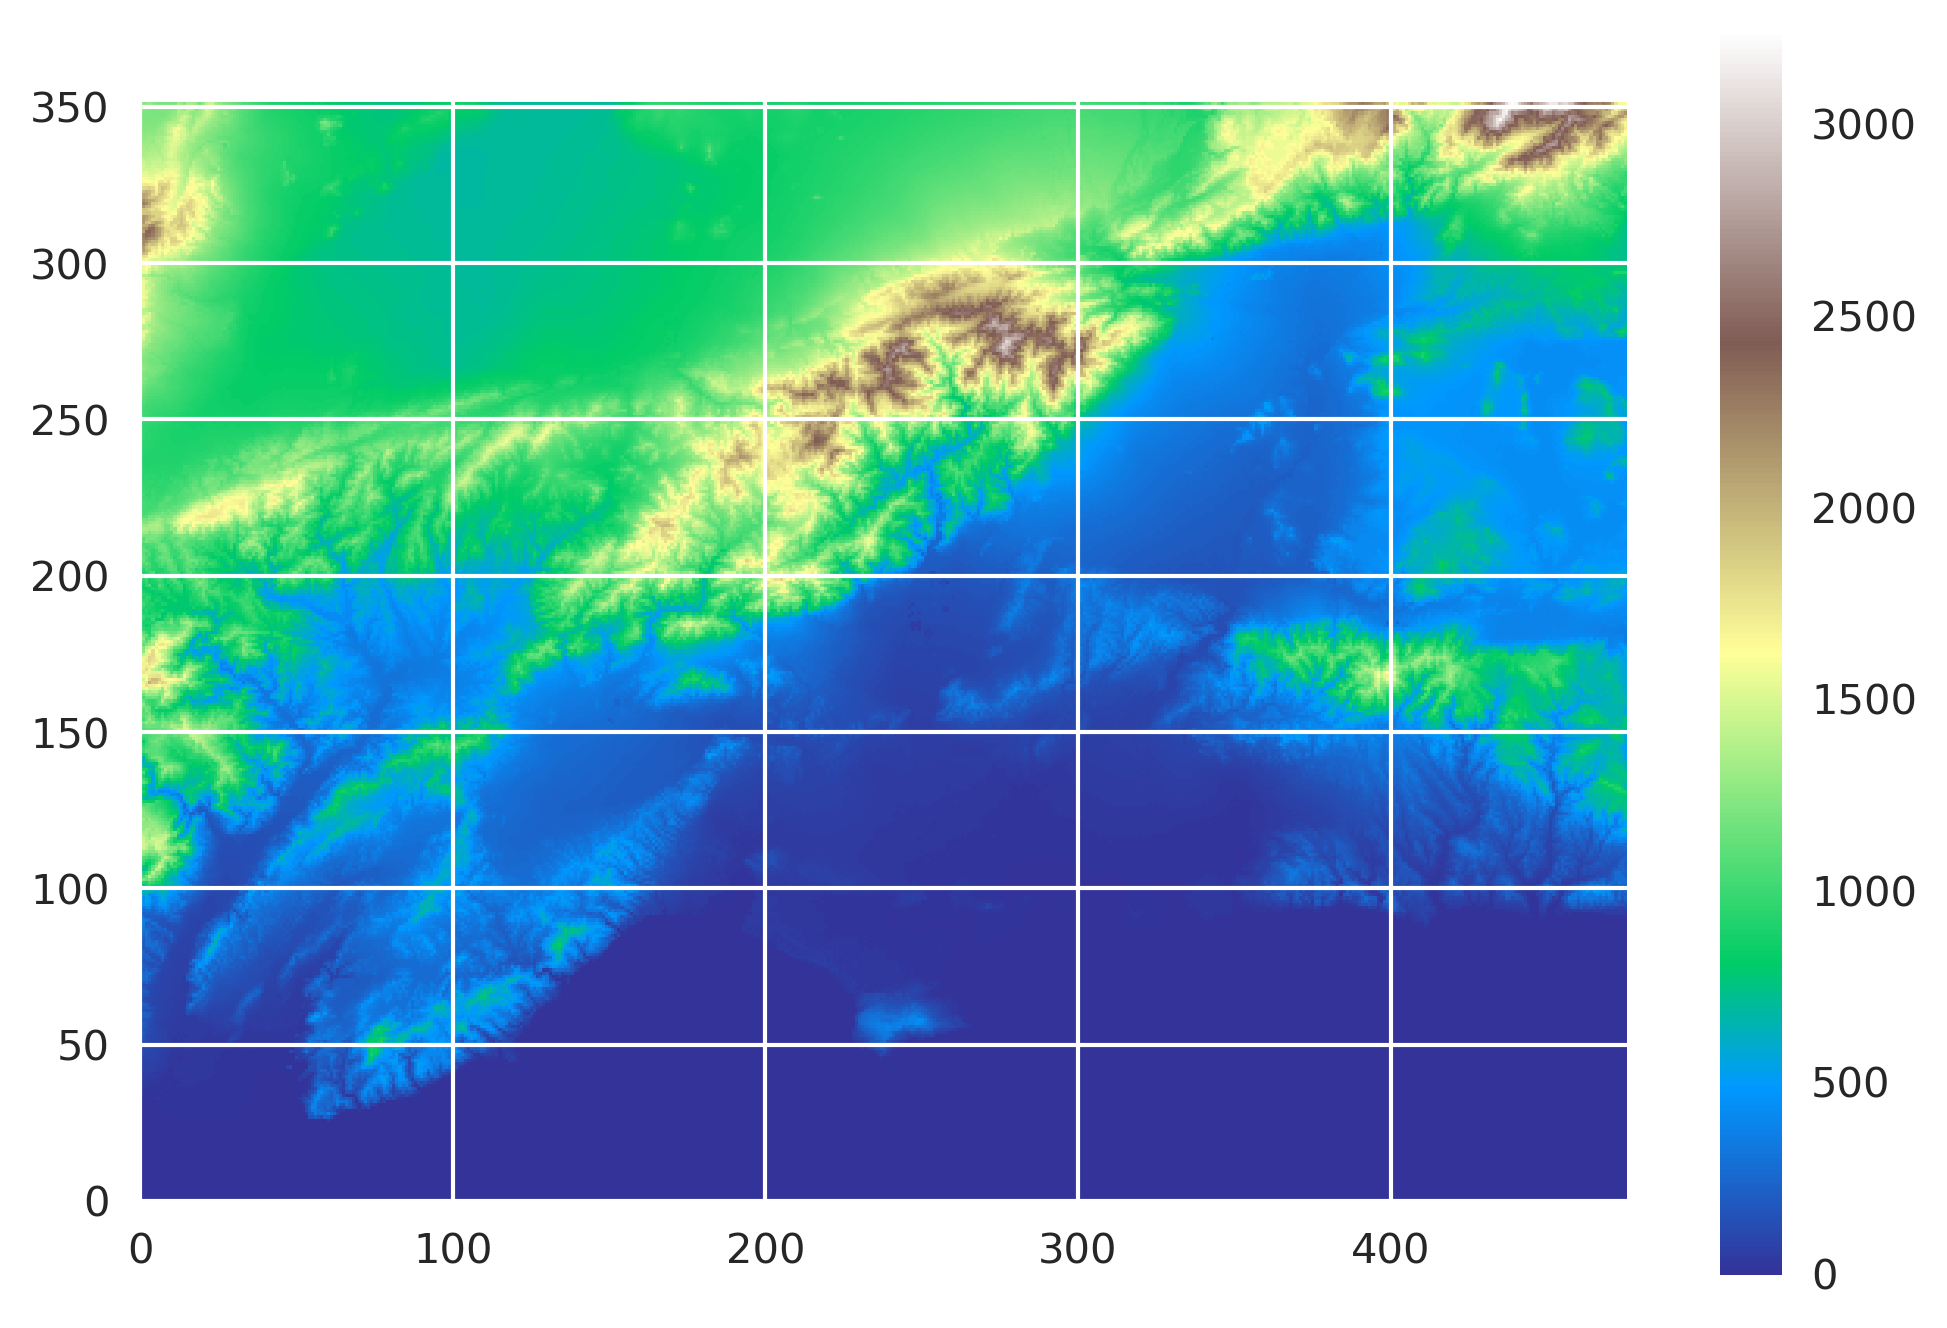

In [9]:
print(f'Topography shape: {topo.shape}')
print(f'Max topo = {np.max(topo)}, Min topo = {np.min(topo)}')
plt.imshow(topo[::20, ::20], cmap='terrain')
plt.gca().invert_yaxis()
plt.colorbar()

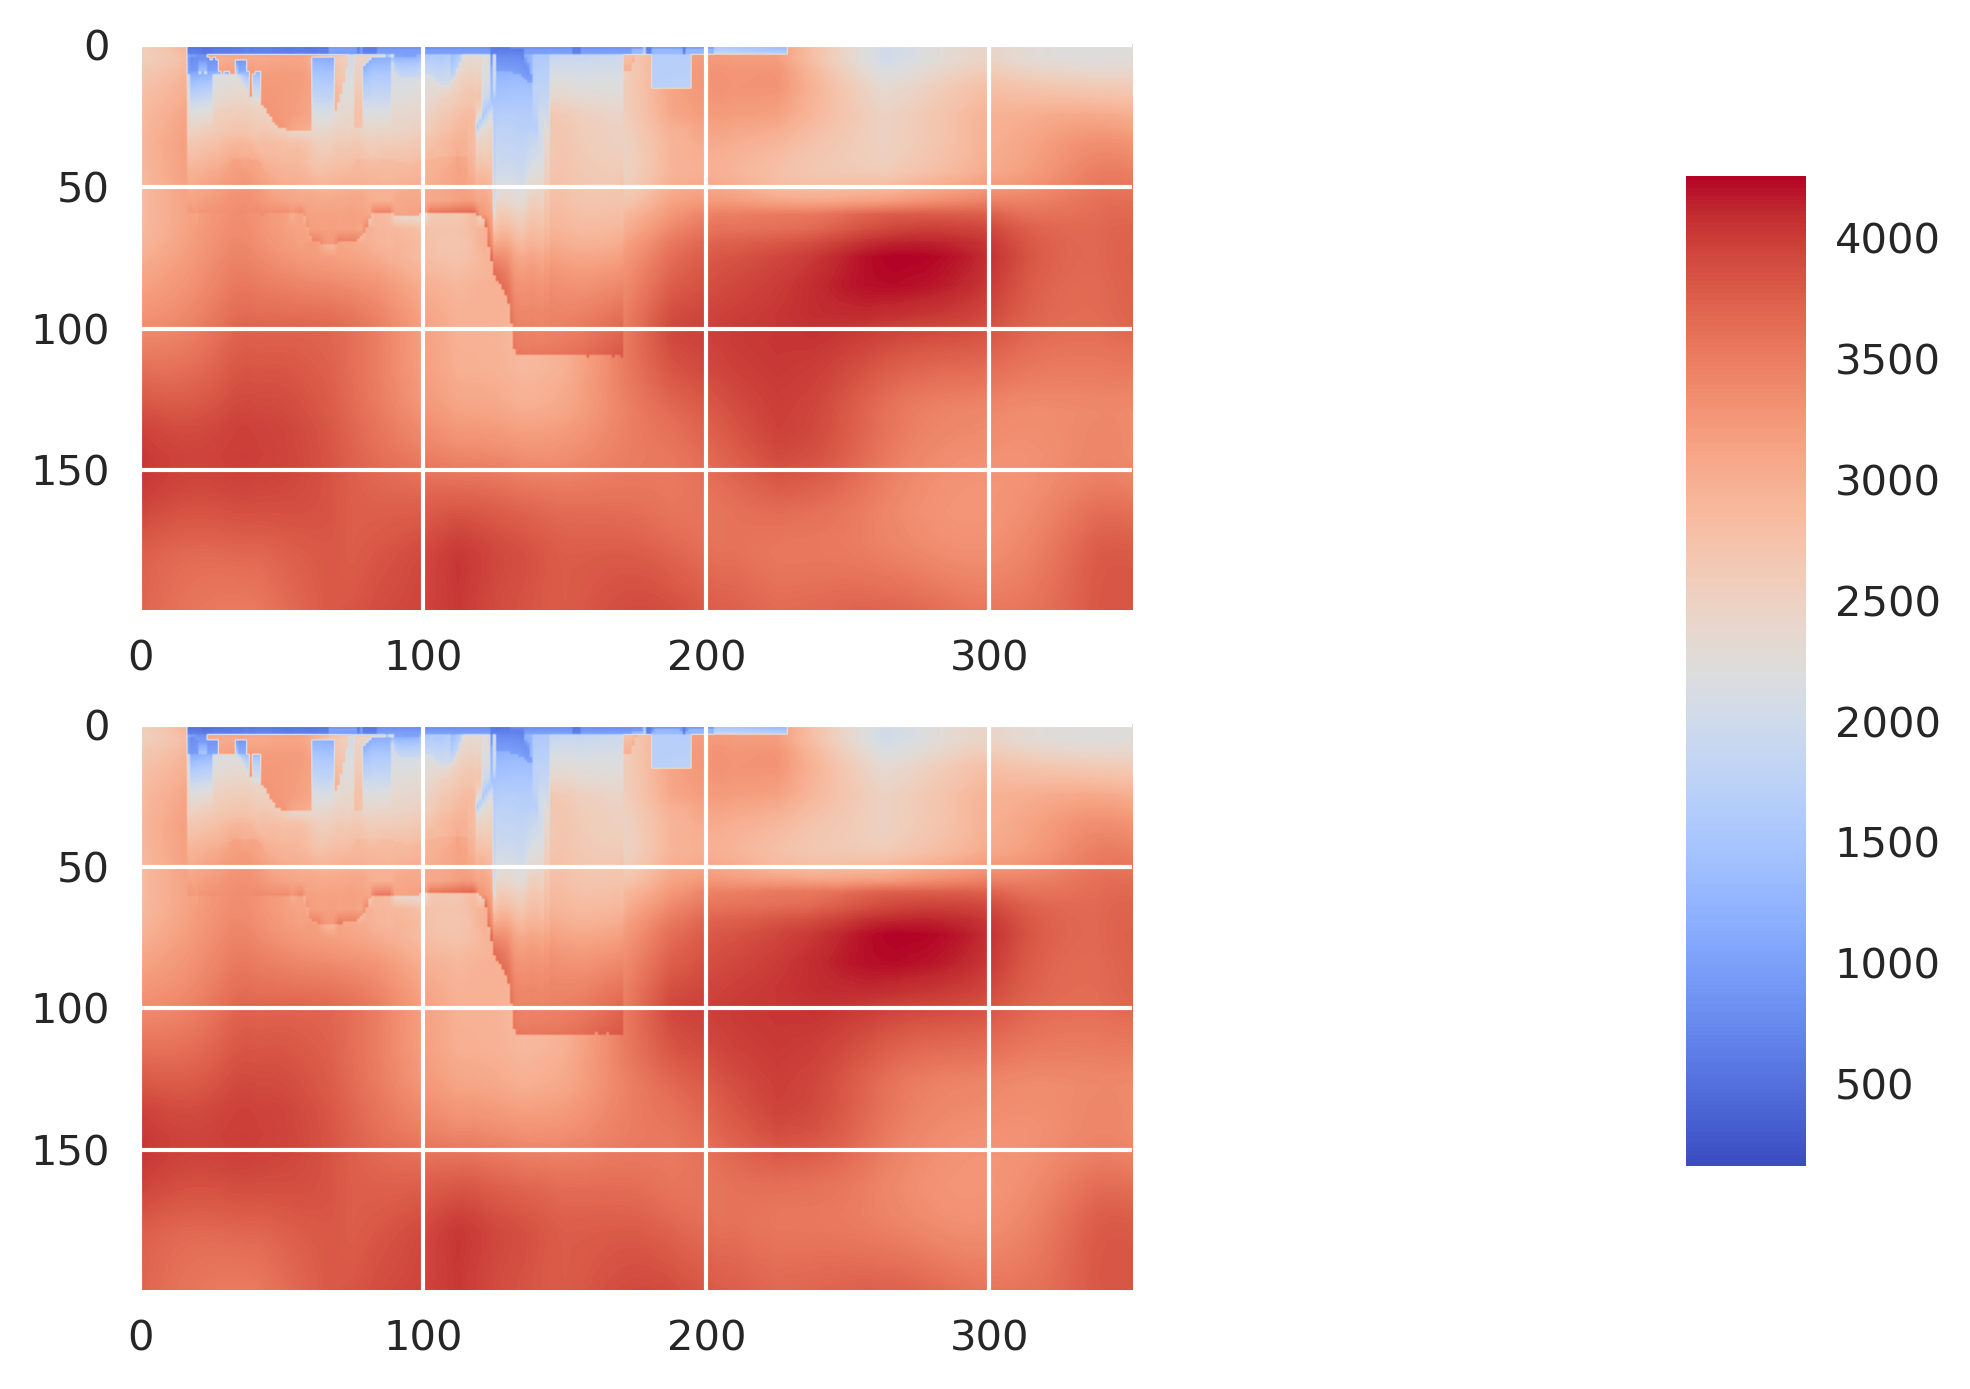

In [31]:
mesh = read_mesh_slice('mesh', 'x', 1000, nx, ny, 1000, skip=5)
mesh_topo = read_mesh_slice('mesh_topo.bin', 'x', 1000, nx, ny, 1000, skip=5)

fig, ax = plt.subplots(2,1)
fig.subplots_adjust(right=0.75)
#fig.tight_layout()
im = ax[0].imshow(mesh[::1, ::4], vmin=np.min(mesh), vmax=np.max(mesh), cmap='coolwarm')
ax[1].imshow(mesh_topo[::1, ::4], vmin=np.min(mesh), vmax=np.max(mesh), cmap='coolwarm')


cax = fig.add_axes([0.8, 0.2, 0.05, 0.6])
plt.colorbar(im, cax=cax, orientation='vertical')

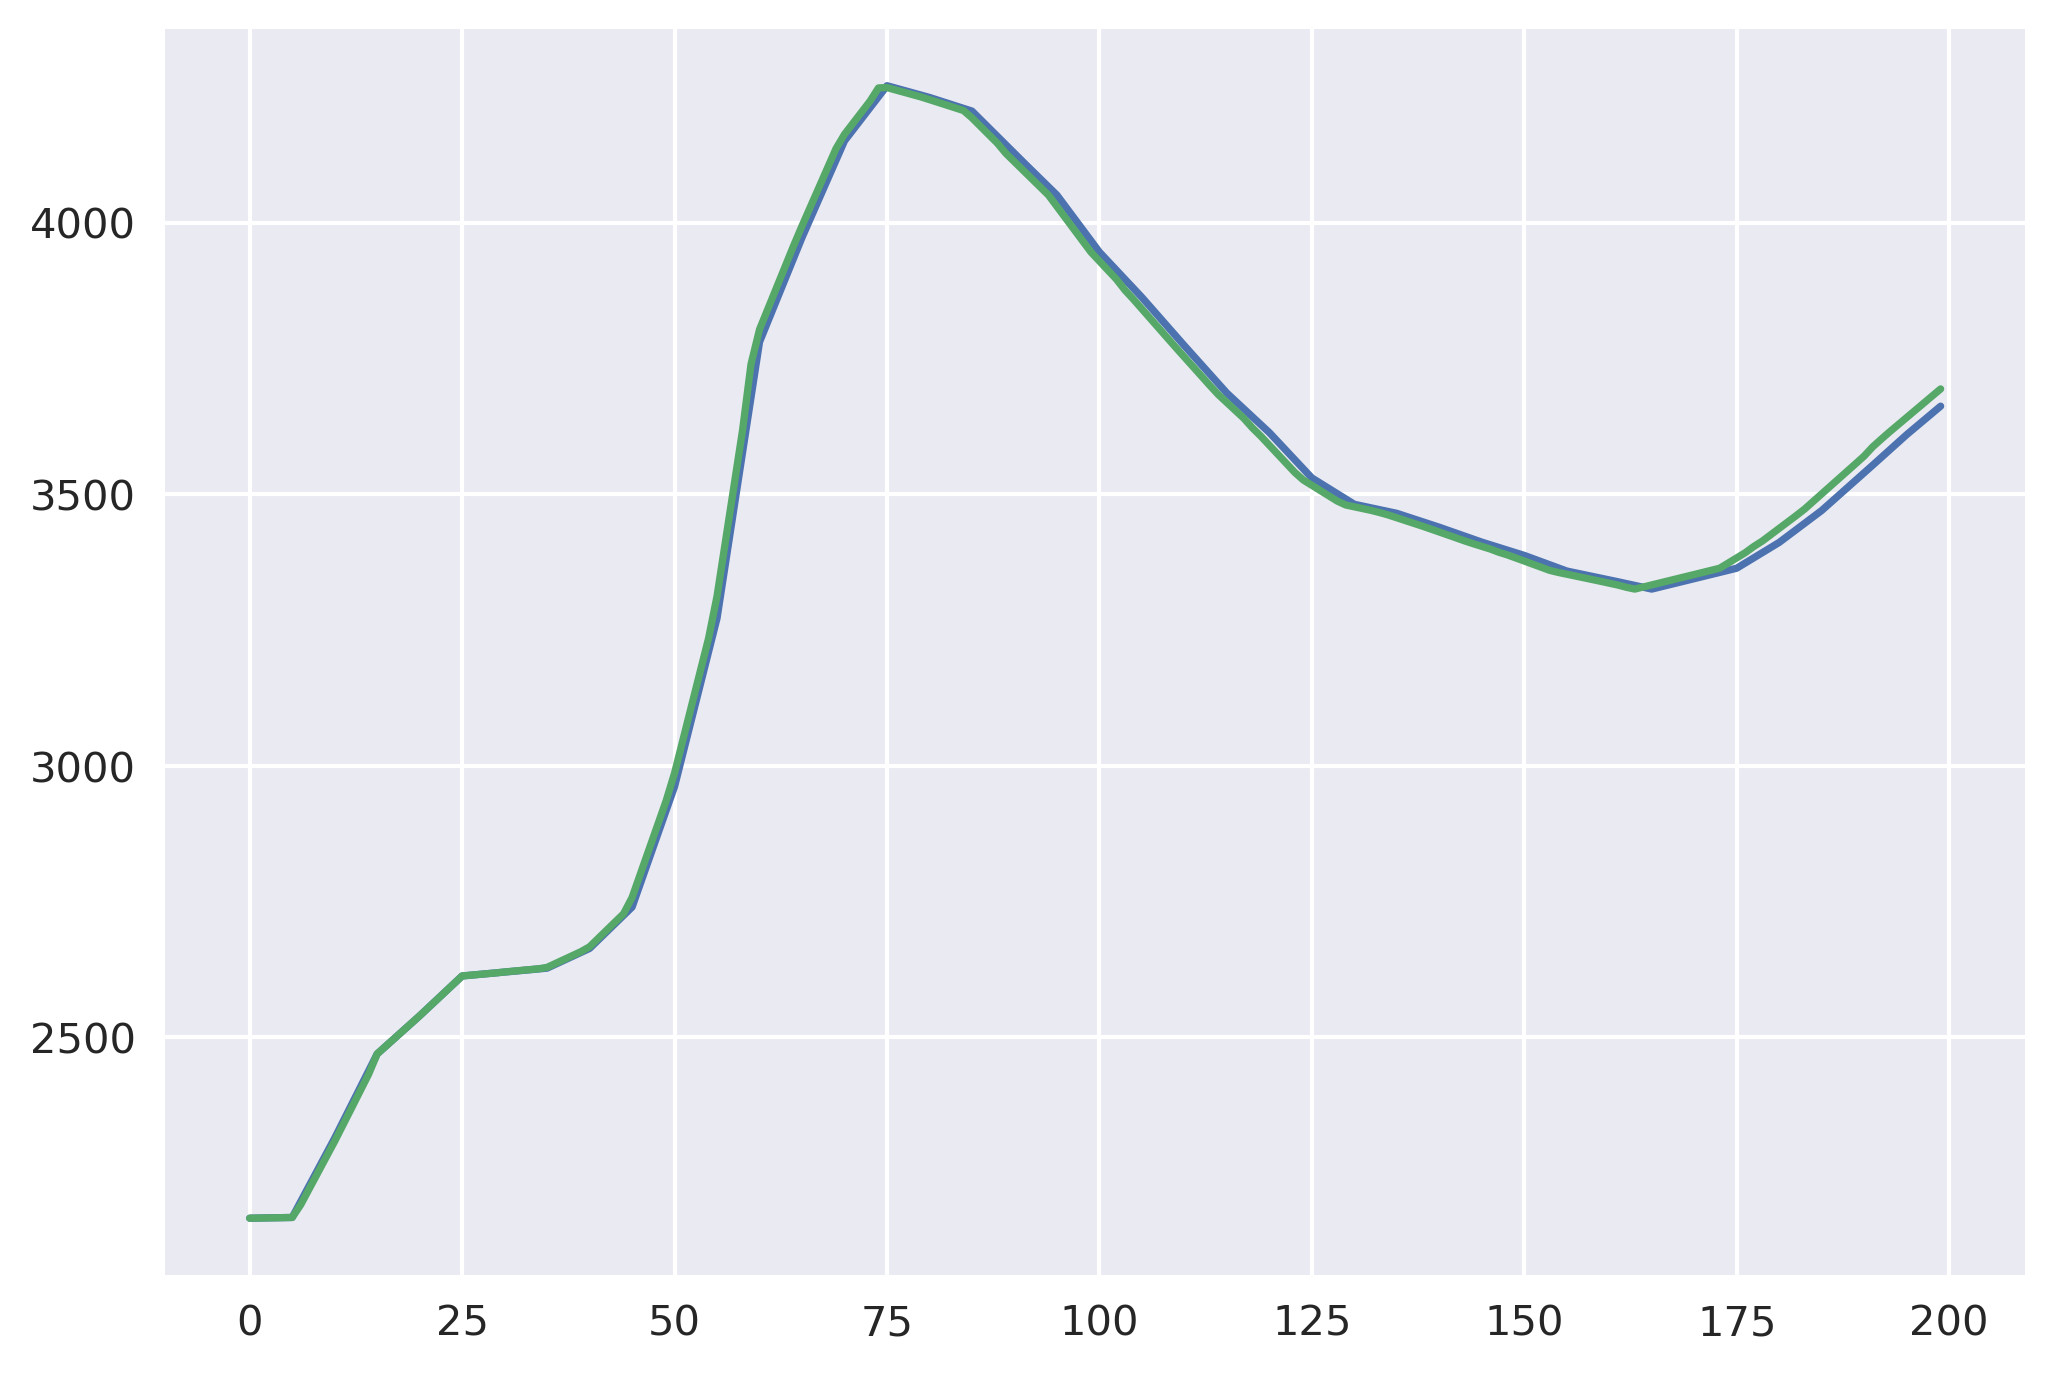

In [37]:
plt.plot(mesh[:, 1100])
plt.plot(mesh_topo[:, 1100])

### Determine dt

In [155]:
t_init = time.time()
difx, dify = compute_gradient(topo, dh, pad)
a = compute_norm(1.0, difx, dify) # 
print(f'Time to compute norm = {time.time() - t_init}')


Time to compute norm = 0.4814338684082031


In [157]:
# mz = 2900  # the number of layers after write_grid
# alpha, normmax = compute_ratio("topography.bin", "mesh_topo.bin",
#                                nx, ny, mz, dh, difx, dify)
# vp_depth, vs_depth, rho_depth = mesh_info("mesh_topo.bin", mz, nx, ny)


Vp max/min: 8518.921875, 167.6300048828125
Vs max/min: 5116.9833984375, 60.959999084472656
Rho max/min: 3150.26953125, 1889.4744873046875
dt has to be smaller than 0.000703821366187185


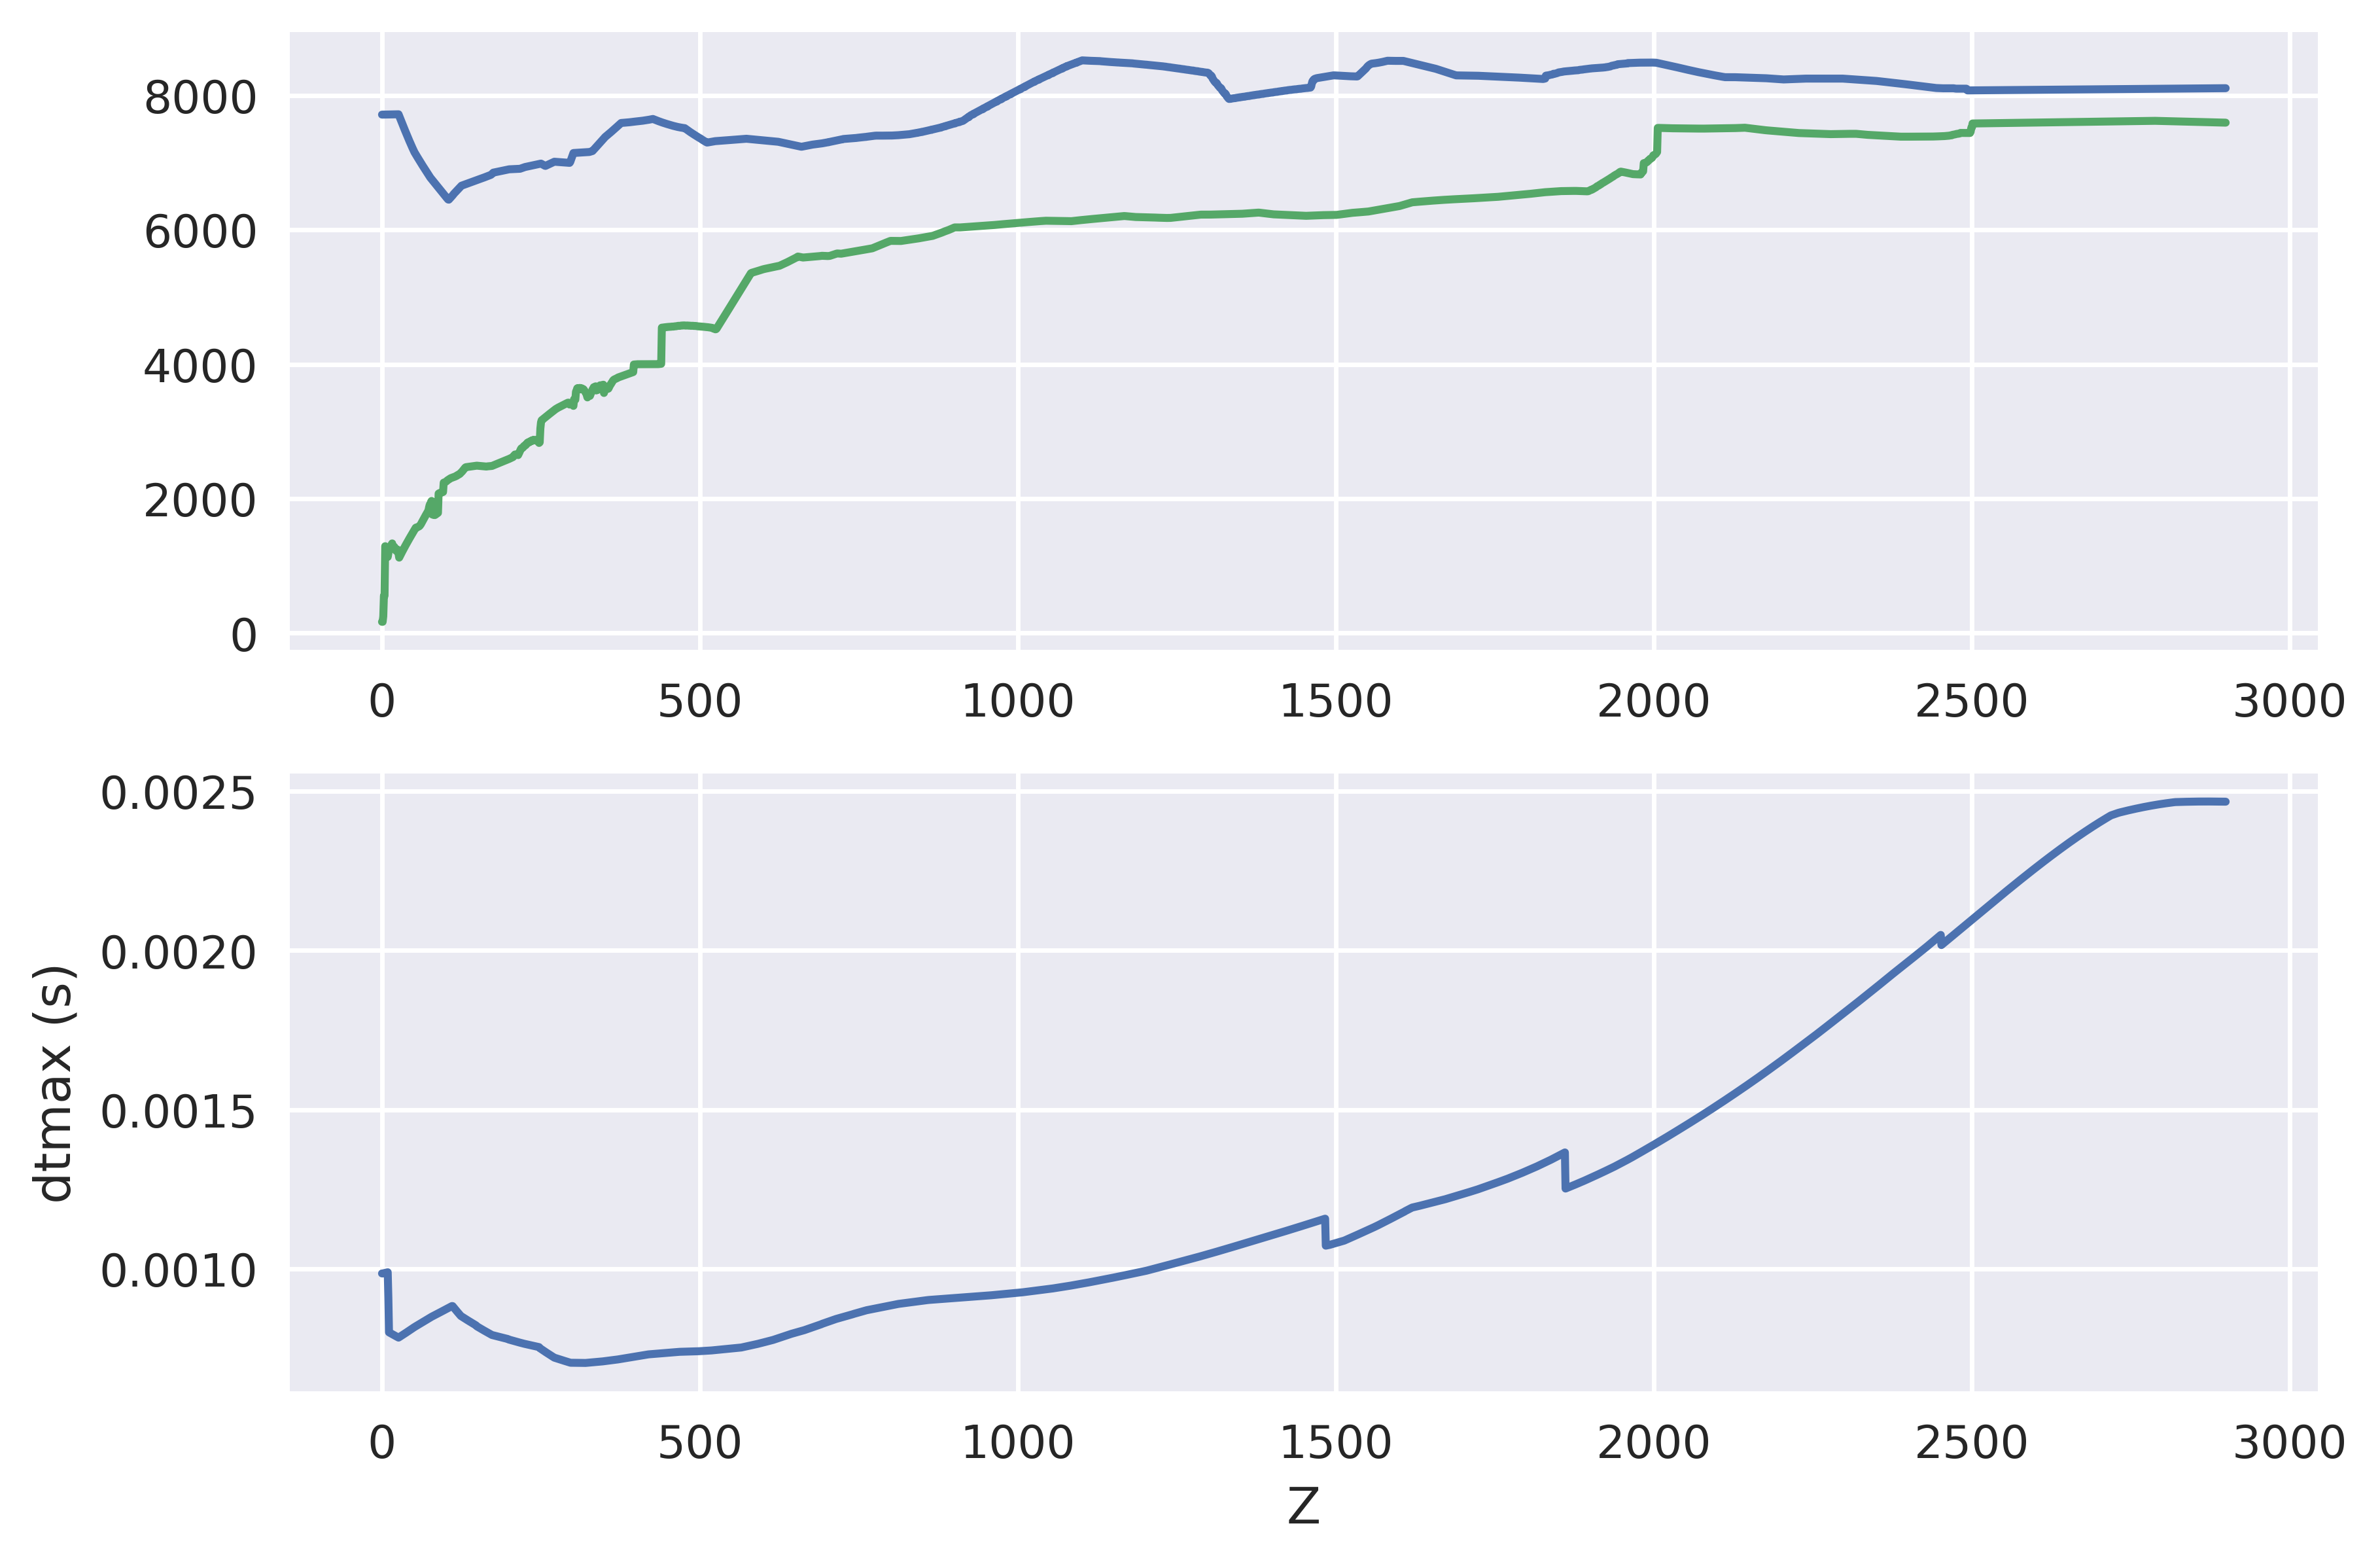

In [159]:
fig, ax = plt.subplots(2, 1, dpi=500)
ax[0].plot(vp_depth[:, 0])
ax[0].plot(vp_depth[:, 1])
print(f'Vp max/min: {np.max(vp_depth)}, {np.min(vp_depth)}')
print(f'Vs max/min: {np.max(vs_depth)}, {np.min(vs_depth)}')
print(f'Rho max/min: {np.max(rho_depth)}, {np.min(rho_depth)}')
ax[1].plot(alpha)
ax[1].set_xlabel('Z')
ax[1].set_ylabel('dtmax (s)')
print(f'dt has to be smaller than {np.min(alpha)}')

In [ ]:
suggest_dt, suggest_vpmax = set_dt_vp(ratio, normmax, dh, alpha=0.6)
print(suggest_dt, suggest_vpmax)